# Lezione 12 – Overfitting e Underfitting: Diagnosi e Rimedi

---

## Mappa della Lezione

| # | Sezione | Domanda-guida | Minuti |
|---|---------|---------------|--------|
| 1 | Obiettivi e prerequisiti | Perché devo capire overfit/underfit? | 3 |
| 2 | Teoria profonda e rationale | Cos'è il trade-off bias-varianza? | 25 |
| 3 | Schema mentale / mappa decisionale | Come diagnostico il problema? | 5 |
| 4 | Sezione dimostrativa | Come visualizzo le learning curves? | 25 |
| 5 | Esercizi e consolidamento | Riesco a diagnosticare e risolvere? | 15 |
| 6 | Conclusione operativa | Cosa porto a casa? | 3 |
| 7 | Checklist di fine lezione | Sono pronto per proseguire? | 2 |
| 8 | Changelog didattico | Come si è evoluto il materiale? | 1 |

---

## Obiettivi di Apprendimento

| ID | Obiettivo | Verifica | Livello |
|----|-----------|----------|---------|
| O1 | Comprendere il trade-off bias-varianza | Spiegare perché non puoi minimizzare entrambi | 🟢 Fondamentale |
| O2 | Riconoscere overfitting da train/test gap | Identificare gap > 10% come segnale di allarme | 🟢 Fondamentale |
| O3 | Riconoscere underfitting da train score | Train score < 80% indica modello troppo semplice | 🟡 Intermedio |
| O4 | Interpretare learning curves | Leggere grafici train vs val al variare dei dati | 🟡 Intermedio |
| O5 | Applicare rimedi specifici per ogni problema | Scegliere l'azione corretta (più/meno complessità) | 🔴 Avanzato |
| O6 | Scegliere la complessità ottimale | Trovare il sweet spot bias-varianza | 🔴 Avanzato |

---

## Prerequisiti

| Requisito | Lezione | Concetto chiave | Auto-verifica |
|-----------|---------|-----------------|---------------|
| Train/Test Split | Lesson 11 | Separare dati per validazione | Sai usare train_test_split? |
| Cross-Validation | Lesson 11 | K-Fold CV per stima robusta | Sai interpretare cv scores? |
| Decision Tree | Lesson 09 | max_depth come regolatore complessità | Sai cosa fa max_depth? |
| Metriche di valutazione | Lesson 11 | Accuracy, F1, confronto train/test | Sai calcolare gap train-test? |

> ⚠️ **Questa è una lezione DIAGNOSTICA**: imparerai a leggere i "sintomi" del tuo modello per prescrivere la "cura" giusta.

---

## Perché Questa Lezione È Cruciale

### Il Problema Centrale del Machine Learning

L'obiettivo del ML NON è predire bene i dati già visti. L'obiettivo è predire bene **dati nuovi, mai visti**.

| Situazione | Cosa Misuri | Cosa Ti Interessa |
|------------|-------------|-------------------|
| Train Score alto | Memorizzazione | ❌ Non informativo |
| Test Score alto | Generalizzazione | ✅ L'unica cosa che conta |
| Gap Train-Test alto | Overfitting | ❌ Problema serio |

### I Due Modi per Fallire

| Problema | Bias | Varianza | Segnali | Cura |
|----------|------|----------|---------|------|
| **Underfitting** | Alto | Basso | Train basso, Test basso, Gap piccolo | ↑ Complessità |
| **Overfitting** | Basso | Alto | Train alto, Test basso, Gap grande | ↓ Complessità |
| **Giusto** | Medio | Medio | Train alto, Test alto, Gap piccolo | ✅ Mantieni |

---

## La Formula del Trade-Off

$$\text{Errore Totale} = \text{Bias}^2 + \text{Varianza} + \text{Rumore Irriducibile}$$

| Componente | Significato | Causa |
|------------|-------------|-------|
| Bias² | Errore per semplificazione eccessiva | Modello troppo semplice |
| Varianza | Sensibilità ai dati specifici | Modello troppo complesso |
| Rumore | Errore intrinseco nei dati | Inevitabile, non eliminabile |

**Non puoi minimizzare bias e varianza contemporaneamente** → devi trovare il compromesso ottimale.

---

## Intuizione Visiva

```
    Errore
      ↑
      |     *
      |    * *    ← Errore Totale (U-shape)
      |   *   *
      |  *     * *
      | *  Varianza*
      |*            * ← Bias²
      +--------------------→ Complessità Modello
        Semplice    Complesso
        
     Underfitting ← SWEET SPOT → Overfitting
```

---

## Librerie Utilizzate

```python
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
```

---

## Navigazione Veloce

- [Teoria bias-varianza](#2-teoria-concettuale-profonda)
- [Schema diagnostico](#3-schema-mentale--mappa-decisionale)
- [Learning curves](#4-sezione-dimostrativa)
- [Conclusione](#6-conclusione-operativa)

# 2) Teoria concettuale profonda

## 1.1 Il Problema Fondamentale: Generalizzazione

L'obiettivo del machine learning NON e predire bene i dati che il modello ha gia visto.
L'obiettivo e predire bene **dati nuovi, mai visti**. Questa capacita si chiama **generalizzazione**.

```
               TRAINING DATA                    NUOVI DATI
              +--------------+                 +--------------+
              |  * * * * * * |                 |  ? ? ? ? ? ? |
              |  * * * * * * |  --> Modello -> |  ? ? ? ? ? ? |
              |  * * * * * * |                 |  ? ? ? ? ? ? |
              +--------------+                 +--------------+
                   Noti                            Ignoti
                   
         Performance qui != Performance qui!
```

---

## 1.2 Due Modi per Fallire

### UNDERFITTING (Bias Alto)

Il modello e **troppo semplice** per catturare i pattern reali:

```
Dati reali: curva complessa
Modello: retta

         |    *
    y    |  *   **
         |*-------*---  <-- Retta (underfitting)
         |    *     **
         +---------------
                 x
```

**Segnali:**
- Errore alto sul training set
- Errore alto sul test set
- I due errori sono simili

### OVERFITTING (Varianza Alta)

Il modello e **troppo complesso** e memorizza il rumore:

```
Dati reali: curva semplice + rumore
Modello: curva che passa per ogni punto

         |    *
    y    |  */ \**
         |*/    \*/\  <-- Curva troppo complessa (overfitting)
         |        \**
         +---------------
                 x
```

**Segnali:**
- Errore basso sul training set
- Errore alto sul test set
- Grande gap tra i due errori

---

## 1.3 Decomposizione dell'Errore

L'errore totale di un modello puo essere scomposto in tre componenti:

$$\text{Errore Totale} = \text{Bias}^2 + \text{Varianza} + \text{Rumore Irriducibile}$$

### Bias (Errore Sistematico)

Il **bias** misura quanto le predizioni del modello si discostano sistematicamente dai valori reali.

| Caratteristica | Bias Alto | Bias Basso |
|----------------|-----------|------------|
| Complessita | Modello troppo semplice | Modello flessibile |
| Pattern | Non cattura i pattern | Cattura bene i pattern |
| Predizioni | Lontane dai valori veri | Vicine ai valori veri |

### Varianza (Sensibilita ai Dati)

La **varianza** misura quanto le predizioni cambiano se alleni il modello su dati diversi.

| Caratteristica | Varianza Bassa | Varianza Alta |
|----------------|----------------|---------------|
| Stabilita | Predizioni consistenti | Predizioni instabili |
| Training diversi | Risultati simili | Risultati molto diversi |
| Sensibilita | Robusta al rumore | Sensibile al rumore |

---

## 1.4 Il Trade-Off Bias-Varianza

**Non puoi minimizzare entrambi contemporaneamente!**

```
Errore |
       | \                    /
       |  \   Bias^2         / Varianza
       |   \               /
       |    \            /
       |     \    *    /   <-- Punto ottimo
       |      \------/
       |        \/ Errore Totale
       +---------------------------
              Complessita Modello -->
              
    Semplice <-----------------> Complesso
    (Underfitting)              (Overfitting)
```

| Complessita | Bias | Varianza | Rischio |
|-------------|------|----------|---------|
| Troppo bassa | Alto | Bassa | Underfitting |
| Giusta | Bilanciato | Bilanciato | Generalizzazione |
| Troppo alta | Basso | Alta | Overfitting |

---

## 1.5 Learning Curves: Diagnosticare Overfitting

Le **learning curves** (curve di apprendimento) mostrano come cambia la performance del modello al variare della **quantita di dati di training**.

### Caso 1: UNDERFITTING (Bias Alto)

```
Score |
      | -----------------  <-- Train score (basso)
      | -----------------  <-- Validation score (basso)
      |
      +-----------------------------
            Training Size -->
            
Entrambi bassi e vicini = modello troppo semplice
```

### Caso 2: OVERFITTING (Varianza Alta)

```
Score |
      | -----------------  <-- Train score (alto)
      |
      |        ----------  <-- Validation score (piu basso)
      | GAP!
      +-----------------------------
            Training Size -->
            
Grande gap tra train e validation = overfitting
```

### Caso 3: BUONA GENERALIZZAZIONE

```
Score |
      | ----------------  <-- Train score
      | ----------------  <-- Validation score (vicino)
      |
      +-----------------------------
            Training Size -->
            
Entrambi alti e vicini = modello che generalizza bene
```

---

## 1.6 Segnali Pratici nei Dati

### Tabella Diagnostica

| Segnale | Underfitting | Overfitting |
|---------|--------------|-------------|
| Errore Training | Alto | Basso |
| Errore Test/Val | Alto | Alto |
| Gap Train-Test | Piccolo | Grande |
| Learning Curve | Entrambe basse | Train alta, Val bassa |
| Cross-Val Std | Bassa | Alta |

### Red Flags per Overfitting

1. Accuracy training circa 100% ma validation molto piu bassa
2. Grande variabilita tra i fold della cross-validation
3. Modello molto complesso rispetto alla quantita di dati
4. Troppe feature rispetto ai campioni (p >> n)
5. Iperparametri non regolati (es. albero senza max_depth)

### Red Flags per Underfitting

1. Performance deludente anche sul training set
2. Modello troppo semplice per il problema
3. Feature poco informative o mancanti
4. Preprocessing inadeguato

---

## 1.7 Rimedi

### Per Overfitting (Ridurre Varianza)

| Strategia | Come Funziona |
|-----------|---------------|
| Piu dati | Piu campioni = meno memorizzazione |
| Regolarizzazione | Penalizza complessita (L1, L2) |
| Ridurre complessita | Meno parametri, max_depth, min_samples |
| Ensemble | Random Forest, Bagging riducono varianza |
| Early stopping | Ferma training prima che memorizzi |
| Dropout (DL) | Disattiva neuroni casualmente |

### Per Underfitting (Ridurre Bias)

| Strategia | Come Funziona |
|-----------|---------------|
| Modello piu complesso | Piu parametri, reti piu profonde |
| Piu feature | Feature engineering |
| Meno regolarizzazione | Riduci penalita |
| Train piu a lungo | Piu epoche/iterazioni |
| Preprocessing migliore | Scaling, encoding corretti |

---

## 1.8 Regole d'Oro

1. **Mai valutare solo sul training set** - Il test score e quello che conta
2. **Gap > 10% = campanello d'allarme** - Indica overfitting
3. **Usa sempre cross-validation** - Per stime robuste
4. **Piu dati aiutano contro overfitting** - Ma non contro underfitting
5. **Regolarizzazione aiuta contro overfitting** - L1, L2, dropout

# 3) Schema mentale / mappa decisionale

## 2.1 Schema Diagnosi Overfitting/Underfitting

```
HO ADDESTRATO UN MODELLO
          |
          v
    +------------------+
    | Train Score      |
    |    alto?         |
    +--------+---------+
             |
     +-------+-------+
     |               |
    NO              SI
     |               |
     v               v
+-----------+    +-------------+
|UNDERFITTING|   |Test Score   |
|           |    |alto?        |
| Aumenta   |    +------+------+
|complessita|           |
+-----------+    +------+------+
                 |             |
                SI            NO
                 |             |
                 v             v
           +---------+   +-------------+
           | OTTIMO! |   |OVERFITTING  |
           |         |   |             |
           | Modello |   | Riduci      |
           |generalizza| |complessita  |
           +---------+   |o piu dati   |
                         +-------------+
```

---

## 2.2 Decisione Complessita Modello

```
PROBLEMA DI ML
      |
      v
+-----------------------+
| Quanti dati ho?       |
| Quante feature?       |
+-----------+-----------+
            |
    +-------+-------+
    |               |
  POCHI           MOLTI
    |               |
    v               v
+----------+    +----------+
| Modello  |    | Modello  |
| semplice |    | complesso|
| (bias    |    | (bias    |
| alto)    |    | basso)   |
+-----+----+    +-----+----+
      |               |
      v               v
+-----------+   +-----------+
| Se va male:|   | Se va male:|
| Underfitting|  | Overfitting|
| --> aumenta|   | --> riduci |
| complessita|   | complessita|
+-----------+   | o piu dati |
                +-----------+
```

---

## 2.3 Workflow Learning Curves

```
VOGLIO DIAGNOSTICARE IL MIO MODELLO
                |
                v
+-------------------------------+
| learning_curve(model, X, y,   |
|    cv=5, train_sizes=...)     |
+---------------+---------------+
                |
                v
+-------------------------------+
| Plot: train_score vs          |
|       validation_score        |
+---------------+---------------+
                |
        +-------+-------+
        |       |       |
        v       v       v
   +--------+ +--------+ +--------+
   |Entrambi| |Train OK| |Train OK|
   |bassi   | |Val OK  | |Val basso|
   +---+----+ +---+----+ +----+---+
       |          |           |
       v          v           v
   +--------+ +--------+ +----------+
   |UNDER-  | |BUONA   | |OVER-     |
   |FITTING | |GENERAL.| |FITTING   |
   +--------+ +--------+ +----------+
       |          |           |
       v          v           v
   +--------+ +--------+ +----------+
   |Aumenta | |Modello | |Riduci    |
   |complex.| |pronto! | |complex.  |
   +--------+ +--------+ +----------+
```

---

## 2.4 Scelta del Rimedio

```
PROBLEMA IDENTIFICATO
         |
    +----+----+
    |         |
    v         v
UNDERFITTING  OVERFITTING
    |              |
    v              v
+---------+   +------------+
|Aumenta: |   |Riduci:     |
|- depth  |   |- depth     |
|- n_est. |   |- n_estim.  |
|- feature|   |- feature   |
+---------+   +------------+
    |              |
    v              v
+---------+   +------------+
|Riduci:  |   |Aumenta:    |
|- regol. |   |- regolariz.|
|         |   |- min_samples|
+---------+   +------------+
    |              |
    v              v
+---------+   +------------+
|Migliora:|   |Aggiungi:   |
|- preproc|   |- piu dati  |
|- feature|   |- dropout   |
| engineer|   |- early stop|
+---------+   +------------+
```

---

## 2.5 Checklist Rapida Diagnosi

```
+------------------------------------------+
|           CHECKLIST DIAGNOSI             |
+------------------------------------------+
|                                          |
| [ ] Train score alto (> 0.80)?           |
|     NO --> Underfitting                  |
|                                          |
| [ ] Test score alto (> 0.75)?            |
|     NO --> Problema di generalizzazione  |
|                                          |
| [ ] Gap train-test < 0.10?               |
|     NO --> Overfitting                   |
|                                          |
| [ ] CV std < 0.05?                       |
|     NO --> Modello instabile             |
|                                          |
| TUTTI SI --> Modello OK!                 |
+------------------------------------------+
```

# 4) Sezione dimostrativa

Questa sezione contiene 6 esercizi pratici completamente risolti per padroneggiare la diagnosi di overfitting e underfitting.

| Esercizio | Tema | Obiettivo |
|-----------|------|-----------|
| 1 | Bias vs Varianza con Polinomi | Visualizzare underfitting/overfitting |
| 2 | Learning Curves Diagnostiche | Interpretare curve di apprendimento |
| 3 | Train vs Test al Variare della Complessita | Trovare il punto di overfitting |
| 4 | Diagnosi Automatica di 3 Modelli | Classificare underfitting/overfitting/ok |
| 5 | Trovare la Complessita Ottimale | Ricerca del miglior iperparametro |
| 6 | Learning Curve Completa con Interpretazione | Analisi completa con rimedi |

Micro-checkpoint 1: Dataset creato con 30 campioni, range [0.10, 4.85]


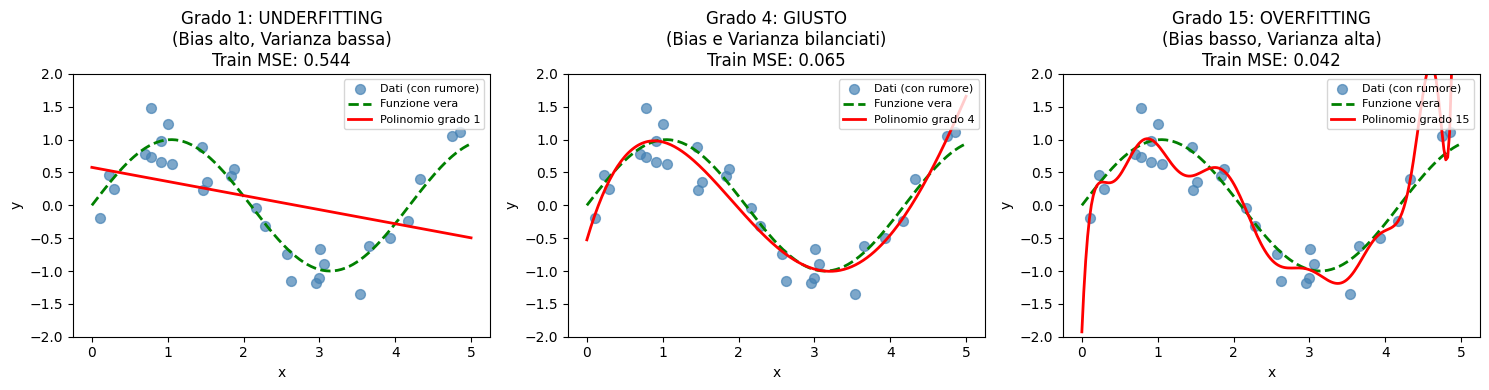


Micro-checkpoint 2: MSE grado 1=0.544, grado 4=0.065, grado 15=0.042
INTERPRETAZIONE

GRADO 1 (Underfitting):
  - Modello troppo semplice (una retta)
  - Non cattura la curva sinusoidale
  - Errore alto anche sul training set

GRADO 4 (Giusto):
  - Complessita adeguata
  - Cattura il pattern senza seguire il rumore
  - Buon compromesso

GRADO 15 (Overfitting):
  - Modello troppo complesso
  - Passa per (quasi) tutti i punti -> basso errore di training
  - Ma oscilla selvaggiamente tra i punti
  - Pessime predizioni su dati nuovi!



In [7]:
# === ESERCIZIO 1: Bias vs Varianza con Regressione Polinomiale ===
# Perche: Visualizzare concretamente cosa significano underfitting e overfitting
#         usando polinomi di grado diverso per fittare una funzione sinusoidale

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# Funzione vera (che il modello NON conosce)
np.random.seed(42)
def true_function(x):
    return np.sin(1.5 * x)

# Generiamo dati con rumore
n_samples = 30
X = np.sort(np.random.uniform(0, 5, n_samples))
y = true_function(X) + np.random.normal(0, 0.3, n_samples)

# --- MICRO-CHECKPOINT 1 ---
assert len(X) == n_samples, "Numero campioni errato"
assert X.min() >= 0 and X.max() <= 5, "Range X non corretto"
print(f"Micro-checkpoint 1: Dataset creato con {n_samples} campioni, range [{X.min():.2f}, {X.max():.2f}]")

# Punti per visualizzazione
X_plot = np.linspace(0, 5, 200)

# Confrontiamo 3 gradi di polinomio
degrees = [1, 4, 15]
titles = ['Grado 1: UNDERFITTING\n(Bias alto, Varianza bassa)', 
          'Grado 4: GIUSTO\n(Bias e Varianza bilanciati)',
          'Grado 15: OVERFITTING\n(Bias basso, Varianza alta)']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
train_mses = []

for ax, degree, title in zip(axes, degrees, titles):
    # Crea modello polinomiale
    model = make_pipeline(
        PolynomialFeatures(degree),
        LinearRegression()
    )
    
    # Allena
    model.fit(X.reshape(-1, 1), y)
    
    # Predici
    y_pred = model.predict(X_plot.reshape(-1, 1))
    y_train_pred = model.predict(X.reshape(-1, 1))
    
    # Calcola errori
    train_mse = mean_squared_error(y, y_train_pred)
    train_mses.append(train_mse)
    
    # Plot
    ax.scatter(X, y, color='steelblue', s=50, alpha=0.7, label='Dati (con rumore)')
    ax.plot(X_plot, true_function(X_plot), 'g--', linewidth=2, label='Funzione vera')
    ax.plot(X_plot, y_pred, 'r-', linewidth=2, label=f'Polinomio grado {degree}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'{title}\nTrain MSE: {train_mse:.3f}')
    ax.legend(loc='upper right', fontsize=8)
    ax.set_ylim(-2, 2)

plt.tight_layout()
plt.show()

# --- MICRO-CHECKPOINT 2 ---
assert train_mses[0] > train_mses[1], "Grado 1 dovrebbe avere MSE > Grado 4"
assert train_mses[2] < train_mses[0], "Grado 15 dovrebbe avere MSE < Grado 1"
print(f"\nMicro-checkpoint 2: MSE grado 1={train_mses[0]:.3f}, grado 4={train_mses[1]:.3f}, grado 15={train_mses[2]:.3f}")

# Spiegazione
print("="*70)
print("INTERPRETAZIONE")
print("="*70)
print("""
GRADO 1 (Underfitting):
  - Modello troppo semplice (una retta)
  - Non cattura la curva sinusoidale
  - Errore alto anche sul training set
  
GRADO 4 (Giusto):
  - Complessita adeguata
  - Cattura il pattern senza seguire il rumore
  - Buon compromesso
  
GRADO 15 (Overfitting):
  - Modello troppo complesso
  - Passa per (quasi) tutti i punti -> basso errore di training
  - Ma oscilla selvaggiamente tra i punti
  - Pessime predizioni su dati nuovi!
""")

Micro-checkpoint 1: Dataset 1000 campioni x 20 feature


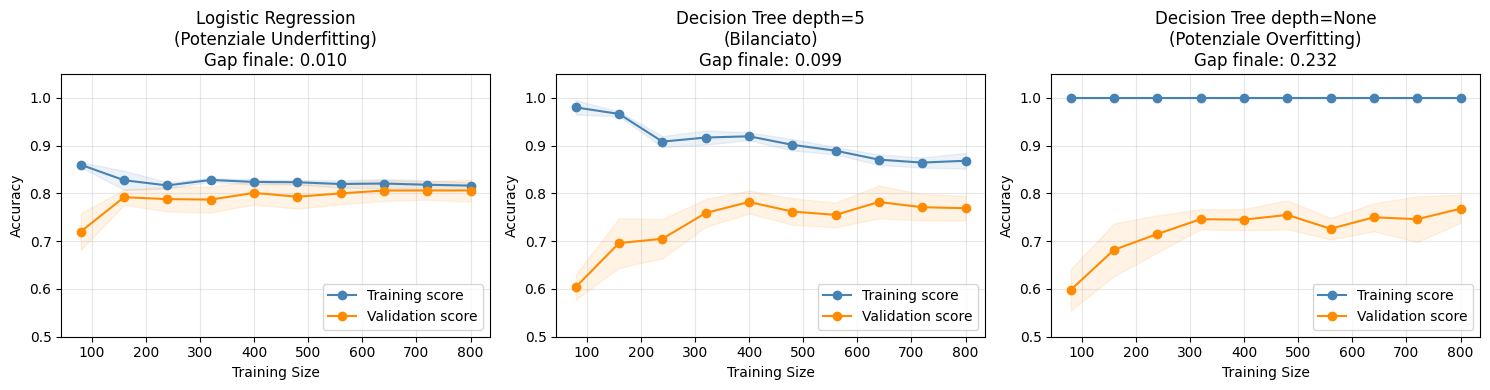


Micro-checkpoint 2: Gap finale - LogReg=0.010, DT(5)=0.099, DT(None)=0.232
COME LEGGERE LE LEARNING CURVES

LOGISTIC REGRESSION:
  - Training e Validation convergono a un valore MEDIO
  - Gap piccolo -> non c'e overfitting
  - Ma il punteggio finale non e altissimo
  - Potrebbe essere UNDERFITTING (modello troppo semplice per i dati)

DECISION TREE (depth=5):
  - Training e Validation convergono bene
  - Gap moderato -> buon compromesso
  - Punteggio finale buono
  - Questo e il comportamento DESIDERATO

DECISION TREE (depth=None):
  - Training score ALTISSIMO (vicino a 1.0)
  - Validation score SIGNIFICATIVAMENTE piu basso
  - Grande GAP -> OVERFITTING!
  - Il modello memorizza i dati di training

REGOLA PRATICA:
  - Gap grande -> riduci complessita del modello
  - Entrambi bassi -> aumenta complessita del modello
  - Entrambi convergono a buon valore -> modello ok



In [8]:
# === ESERCIZIO 2: Learning Curves per Diagnosticare Overfitting ===
# Perche: Le learning curves sono lo strumento principale per diagnosticare
#         problemi di generalizzazione visualizzando train vs validation score

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Creiamo un dataset
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    flip_y=0.1,
    random_state=42
)

# --- MICRO-CHECKPOINT 1 ---
assert X.shape == (1000, 20), "Shape dataset non corretta"
print(f"Micro-checkpoint 1: Dataset {X.shape[0]} campioni x {X.shape[1]} feature")

# Tre modelli con complessita crescente
models = {
    'Logistic Regression\n(Potenziale Underfitting)': LogisticRegression(max_iter=1000),
    'Decision Tree depth=5\n(Bilanciato)': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Decision Tree depth=None\n(Potenziale Overfitting)': DecisionTreeClassifier(max_depth=None, random_state=42)
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
final_gaps = []

for ax, (name, model) in zip(axes, models.items()):
    # Calcola learning curves
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )
    
    # Medie e deviazioni standard
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    # Plot
    ax.plot(train_sizes, train_mean, 'o-', color='steelblue', label='Training score')
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                     alpha=0.1, color='steelblue')
    
    ax.plot(train_sizes, val_mean, 'o-', color='darkorange', label='Validation score')
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                     alpha=0.1, color='darkorange')
    
    # Gap finale
    gap = train_mean[-1] - val_mean[-1]
    final_gaps.append(gap)
    
    ax.set_xlabel('Training Size')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'{name}\nGap finale: {gap:.3f}')
    ax.legend(loc='lower right')
    ax.set_ylim(0.5, 1.05)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# --- MICRO-CHECKPOINT 2 ---
assert final_gaps[2] > final_gaps[1], "DT depth=None dovrebbe avere gap maggiore di depth=5"
print(f"\nMicro-checkpoint 2: Gap finale - LogReg={final_gaps[0]:.3f}, DT(5)={final_gaps[1]:.3f}, DT(None)={final_gaps[2]:.3f}")

# Interpretazione
print("="*70)
print("COME LEGGERE LE LEARNING CURVES")
print("="*70)
print("""
LOGISTIC REGRESSION:
  - Training e Validation convergono a un valore MEDIO
  - Gap piccolo -> non c'e overfitting
  - Ma il punteggio finale non e altissimo
  - Potrebbe essere UNDERFITTING (modello troppo semplice per i dati)

DECISION TREE (depth=5):
  - Training e Validation convergono bene
  - Gap moderato -> buon compromesso
  - Punteggio finale buono
  - Questo e il comportamento DESIDERATO

DECISION TREE (depth=None):
  - Training score ALTISSIMO (vicino a 1.0)
  - Validation score SIGNIFICATIVAMENTE piu basso
  - Grande GAP -> OVERFITTING!
  - Il modello memorizza i dati di training

REGOLA PRATICA:
  - Gap grande -> riduci complessita del modello
  - Entrambi bassi -> aumenta complessita del modello
  - Entrambi convergono a buon valore -> modello ok
""")

Micro-checkpoint 1: Train=350, Test=150
Micro-checkpoint 2: Miglior depth=8 con test score=0.7400


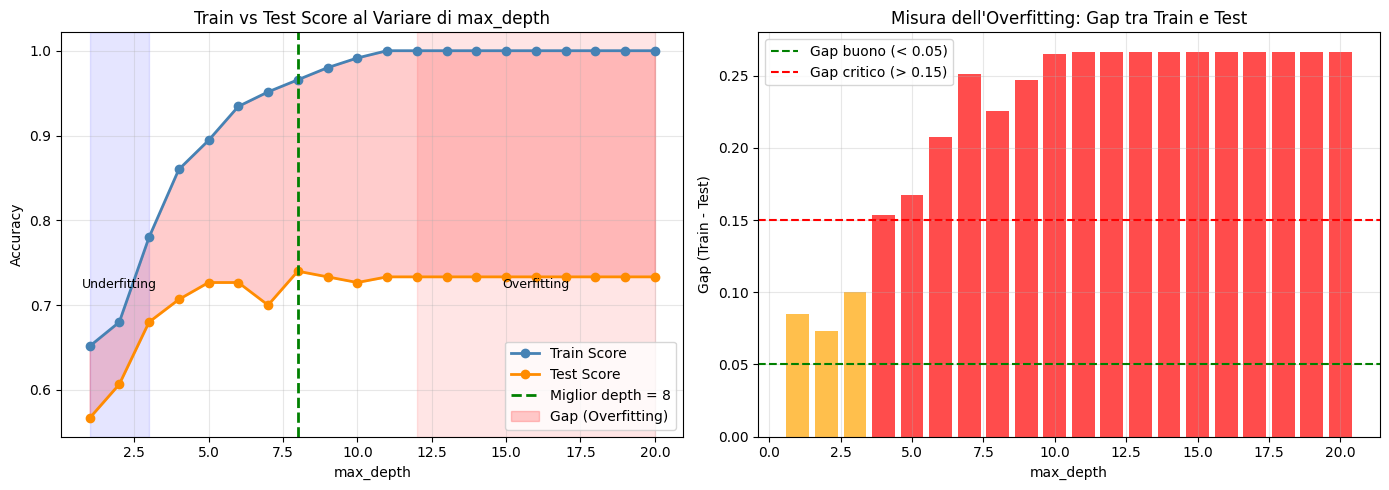

ANALISI DEL TRADE-OFF BIAS-VARIANZA

Miglior max_depth: 8 (Test Accuracy: 0.740)

Depth=1:  Train=0.651, Test=0.567, Gap=0.085
Depth=8:  Train=0.966, Test=0.740, Gap=0.226
Depth=20: Train=1.000, Test=0.733, Gap=0.267

CONCLUSIONI:
  - Depth basso -> Underfitting (entrambi i punteggi bassi)
  - Depth ottimo -> Buon compromesso (test score massimo)
  - Depth alto -> Overfitting (train perfetto, test cala)



In [9]:
# === ESERCIZIO 3: Train vs Test Score al Variare della Complessita ===
# Perche: Dimostra visivamente come aumentando la complessita (max_depth)
#         il train score sale sempre ma il test score prima sale poi scende

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Dataset
X, y = make_classification(
    n_samples=500,
    n_features=15,
    n_informative=8,
    flip_y=0.1,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# --- MICRO-CHECKPOINT 1 ---
assert len(X_train) == 350, f"Atteso 350 campioni train, ottenuto {len(X_train)}"
assert len(X_test) == 150, f"Atteso 150 campioni test, ottenuto {len(X_test)}"
print(f"Micro-checkpoint 1: Train={len(X_train)}, Test={len(X_test)}")

# Testiamo diversi valori di max_depth
depths = range(1, 21)
train_scores = []
test_scores = []

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

# Trova il miglior depth
best_depth = depths[np.argmax(test_scores)]
best_score = max(test_scores)

# --- MICRO-CHECKPOINT 2 ---
assert best_depth > 1 and best_depth < 20, "Il miglior depth dovrebbe essere intermedio"
print(f"Micro-checkpoint 2: Miglior depth={best_depth} con test score={best_score:.4f}")

# Visualizzazione
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Train vs Test Score
ax1 = axes[0]
ax1.plot(depths, train_scores, 'o-', color='steelblue', linewidth=2, label='Train Score')
ax1.plot(depths, test_scores, 'o-', color='darkorange', linewidth=2, label='Test Score')
ax1.axvline(best_depth, color='green', linestyle='--', linewidth=2, 
             label=f'Miglior depth = {best_depth}')
ax1.fill_between(depths, train_scores, test_scores, alpha=0.2, color='red', 
                  label='Gap (Overfitting)')
ax1.set_xlabel('max_depth')
ax1.set_ylabel('Accuracy')
ax1.set_title('Train vs Test Score al Variare di max_depth')
ax1.legend()
ax1.grid(alpha=0.3)

# Annotazioni zone
ax1.axvspan(1, 3, alpha=0.1, color='blue')
ax1.axvspan(12, 20, alpha=0.1, color='red')
ax1.text(2, 0.72, 'Underfitting', ha='center', fontsize=9)
ax1.text(16, 0.72, 'Overfitting', ha='center', fontsize=9)

# Plot 2: Gap (Train - Test)
ax2 = axes[1]
gaps = np.array(train_scores) - np.array(test_scores)
colors = ['green' if g < 0.05 else 'orange' if g < 0.15 else 'red' for g in gaps]
ax2.bar(depths, gaps, color=colors, alpha=0.7)
ax2.axhline(0.05, color='green', linestyle='--', label='Gap buono (< 0.05)')
ax2.axhline(0.15, color='red', linestyle='--', label='Gap critico (> 0.15)')
ax2.set_xlabel('max_depth')
ax2.set_ylabel('Gap (Train - Test)')
ax2.set_title('Misura dell\'Overfitting: Gap tra Train e Test')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Report
print("="*70)
print("ANALISI DEL TRADE-OFF BIAS-VARIANZA")
print("="*70)
print(f"\nMiglior max_depth: {best_depth} (Test Accuracy: {best_score:.3f})")
print(f"\nDepth=1:  Train={train_scores[0]:.3f}, Test={test_scores[0]:.3f}, Gap={train_scores[0]-test_scores[0]:.3f}")
print(f"Depth={best_depth}:  Train={train_scores[best_depth-1]:.3f}, Test={test_scores[best_depth-1]:.3f}, Gap={train_scores[best_depth-1]-test_scores[best_depth-1]:.3f}")
print(f"Depth=20: Train={train_scores[-1]:.3f}, Test={test_scores[-1]:.3f}, Gap={train_scores[-1]-test_scores[-1]:.3f}")

print("""
CONCLUSIONI:
  - Depth basso -> Underfitting (entrambi i punteggi bassi)
  - Depth ottimo -> Buon compromesso (test score massimo)
  - Depth alto -> Overfitting (train perfetto, test cala)
""")

STEP 1: Creazione Dataset
--------------------------------------------------
Training set: 560 campioni
Test set: 240 campioni
Micro-checkpoint 1: Dataset creato correttamente

STEP 2: Definizione Modelli
--------------------------------------------------
Modello A: Albero molto semplice (max_depth=2)
Modello B: Albero moderato (max_depth=6)
Modello C: Albero senza limiti (max_depth=None)

STEP 3: Training e Valutazione

Modello A: Decision Tree (max_depth=2)
  Train Score:  0.7714
  Test Score:   0.7125
  Gap:          0.0589
  CV Std:       0.0360

Modello B: Decision Tree (max_depth=6)
  Train Score:  0.9268
  Test Score:   0.8250
  Gap:          0.1018
  CV Std:       0.0222

Modello C: Decision Tree (max_depth=None)
  Train Score:  1.0000
  Test Score:   0.7667
  Gap:          0.2333
  CV Std:       0.0278

Micro-checkpoint 2: Risultati calcolati correttamente

STEP 4: DIAGNOSI AUTOMATICA

Modello A: Decision Tree (max_depth=2)
  DIAGNOSI: UNDERFITTING
  Spiegazione: Train score t

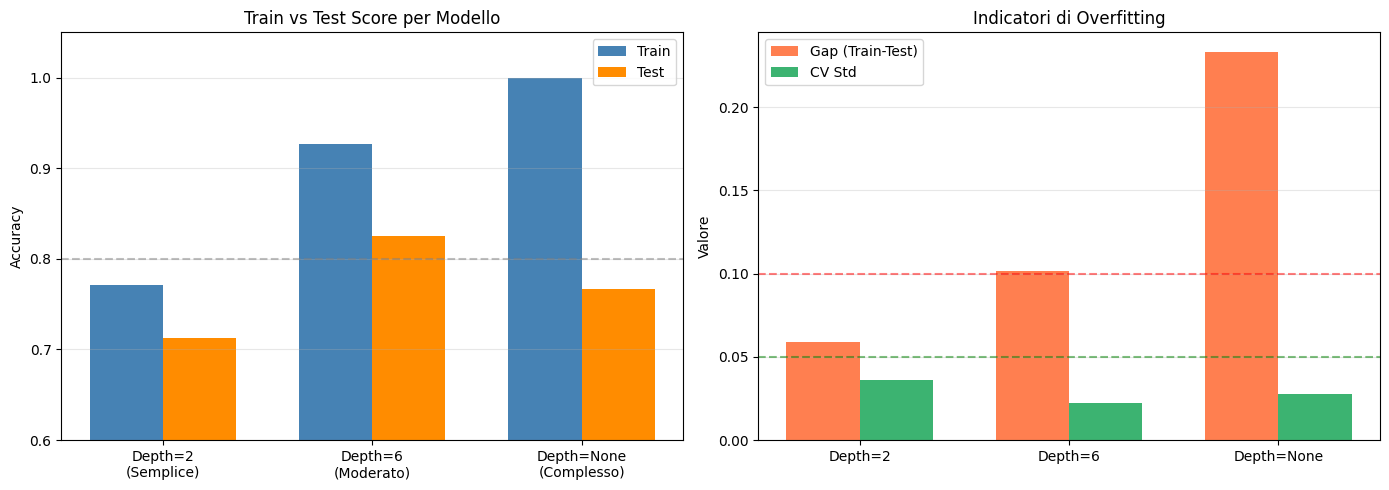


CONCLUSIONE: Il Modello B (depth=6) e il migliore!
Ha il miglior test score con gap accettabile.


In [10]:
# === ESERCIZIO 4: Diagnosi Automatica di 3 Modelli ===
# Perche: Implementare una logica di diagnosi automatica che classifica
#         ogni modello come underfitting, overfitting o buona generalizzazione

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# STEP 1: Creiamo il dataset
print("STEP 1: Creazione Dataset")
print("-" * 50)

X, y = make_classification(
    n_samples=800,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    flip_y=0.05,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"Training set: {X_train.shape[0]} campioni")
print(f"Test set: {X_test.shape[0]} campioni")

# --- MICRO-CHECKPOINT 1 ---
assert X_train.shape[0] == 560, "Numero campioni train errato"
print("Micro-checkpoint 1: Dataset creato correttamente")

# STEP 2: Definiamo tre modelli con complessita diversa
print("\nSTEP 2: Definizione Modelli")
print("-" * 50)

models = {
    'Modello A: Decision Tree (max_depth=2)': DecisionTreeClassifier(max_depth=2, random_state=42),
    'Modello B: Decision Tree (max_depth=6)': DecisionTreeClassifier(max_depth=6, random_state=42),
    'Modello C: Decision Tree (max_depth=None)': DecisionTreeClassifier(max_depth=None, random_state=42)
}

print("Modello A: Albero molto semplice (max_depth=2)")
print("Modello B: Albero moderato (max_depth=6)")
print("Modello C: Albero senza limiti (max_depth=None)")

# STEP 3: Alleniamo e valutiamo ogni modello
print("\nSTEP 3: Training e Valutazione")
print("=" * 70)

results = []

for name, model in models.items():
    # Allena
    model.fit(X_train, y_train)
    
    # Calcola score
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    gap = train_score - test_score
    
    # Cross-validation per std
    cv_scores = cross_val_score(model, X, y, cv=5)
    cv_std = cv_scores.std()
    
    results.append({
        'name': name,
        'train': train_score,
        'test': test_score,
        'gap': gap,
        'cv_std': cv_std
    })
    
    print(f"\n{name}")
    print(f"  Train Score:  {train_score:.4f}")
    print(f"  Test Score:   {test_score:.4f}")
    print(f"  Gap:          {gap:.4f}")
    print(f"  CV Std:       {cv_std:.4f}")

# --- MICRO-CHECKPOINT 2 ---
assert results[0]['train'] < results[2]['train'], "Modello A dovrebbe avere train < Modello C"
print("\nMicro-checkpoint 2: Risultati calcolati correttamente")

# STEP 4: Diagnosi Automatica
print("\n" + "=" * 70)
print("STEP 4: DIAGNOSI AUTOMATICA")
print("=" * 70)

diagnoses = []
for r in results:
    print(f"\n{r['name']}")
    
    # Logica di diagnosi
    if r['train'] < 0.80:
        diagnosis = "UNDERFITTING"
        explanation = "Train score troppo basso. Il modello e troppo semplice."
        action = "-> Aumenta max_depth o usa modello piu complesso"
    elif r['gap'] > 0.10:
        diagnosis = "OVERFITTING"
        explanation = "Gap train-test troppo grande. Il modello memorizza."
        action = "-> Riduci max_depth o aggiungi regolarizzazione"
    else:
        diagnosis = "BUONA GENERALIZZAZIONE"
        explanation = "Train e test score alti e vicini."
        action = "-> Modello pronto per produzione"
    
    diagnoses.append(diagnosis)
    print(f"  DIAGNOSI: {diagnosis}")
    print(f"  Spiegazione: {explanation}")
    print(f"  Azione: {action}")

# --- MICRO-CHECKPOINT 3 ---
assert "UNDERFITTING" in diagnoses, "Dovrebbe esserci almeno un underfitting"
assert "OVERFITTING" in diagnoses, "Dovrebbe esserci almeno un overfitting"
print("\nMicro-checkpoint 3: Diagnosi completata - trovati entrambi i problemi")

# STEP 5: Visualizzazione
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot train vs test
ax1 = axes[0]
x = np.arange(3)
width = 0.35
train_vals = [r['train'] for r in results]
test_vals = [r['test'] for r in results]

bars1 = ax1.bar(x - width/2, train_vals, width, label='Train', color='steelblue')
bars2 = ax1.bar(x + width/2, test_vals, width, label='Test', color='darkorange')

ax1.set_ylabel('Accuracy')
ax1.set_title('Train vs Test Score per Modello')
ax1.set_xticks(x)
ax1.set_xticklabels(['Depth=2\n(Semplice)', 'Depth=6\n(Moderato)', 'Depth=None\n(Complesso)'])
ax1.legend()
ax1.set_ylim(0.6, 1.05)
ax1.axhline(0.8, color='gray', linestyle='--', alpha=0.5)
ax1.grid(axis='y', alpha=0.3)

# Gap e CV std
ax2 = axes[1]
gaps = [r['gap'] for r in results]
cv_stds = [r['cv_std'] for r in results]

ax2.bar(x - width/2, gaps, width, label='Gap (Train-Test)', color='coral')
ax2.bar(x + width/2, cv_stds, width, label='CV Std', color='mediumseagreen')

ax2.set_ylabel('Valore')
ax2.set_title('Indicatori di Overfitting')
ax2.set_xticks(x)
ax2.set_xticklabels(['Depth=2', 'Depth=6', 'Depth=None'])
ax2.legend()
ax2.axhline(0.05, color='green', linestyle='--', alpha=0.5)
ax2.axhline(0.10, color='red', linestyle='--', alpha=0.5)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCONCLUSIONE: Il Modello B (depth=6) e il migliore!")
print("Ha il miglior test score con gap accettabile.")

# 5) Esercizi risolti (step by step)

## Funzioni Sklearn per Diagnosi Overfitting

| Funzione | Import | Descrizione |
|----------|--------|-------------|
| `learning_curve()` | `from sklearn.model_selection import learning_curve` | Genera curve di apprendimento train/val |
| `cross_val_score()` | `from sklearn.model_selection import cross_val_score` | Cross-validation con singola metrica |
| `train_test_split()` | `from sklearn.model_selection import train_test_split` | Divide dataset in train/test |
| `mean_squared_error()` | `from sklearn.metrics import mean_squared_error` | Calcola MSE per regressione |
| `accuracy_score()` | `from sklearn.metrics import accuracy_score` | Calcola accuracy per classificazione |

## Modelli Utilizzati

| Modello | Import | Parametri Chiave per Complessita |
|---------|--------|----------------------------------|
| `DecisionTreeClassifier` | `from sklearn.tree import DecisionTreeClassifier` | `max_depth`, `min_samples_leaf` |
| `RandomForestClassifier` | `from sklearn.ensemble import RandomForestClassifier` | `n_estimators`, `max_depth` |
| `LogisticRegression` | `from sklearn.linear_model import LogisticRegression` | `C` (regolarizzazione) |
| `LinearRegression` | `from sklearn.linear_model import LinearRegression` | Nessuno (modello semplice) |
| `PolynomialFeatures` | `from sklearn.preprocessing import PolynomialFeatures` | `degree` |

## Parametri learning_curve()

```python
train_sizes, train_scores, val_scores = learning_curve(
    estimator=model,           # Modello da valutare
    X=X, y=y,                  # Dataset completo
    train_sizes=np.linspace(0.1, 1.0, 10),  # Frazioni del training set
    cv=5,                      # Numero fold cross-validation
    scoring='accuracy',        # Metrica da usare
    n_jobs=-1,                 # Parallelizzazione
    random_state=42            # Riproducibilita
)
```

## Iperparametri per Controllare Overfitting

| Modello | Parametro | Effetto |
|---------|-----------|---------|
| Decision Tree | `max_depth` | Limita profondita (complessita) |
| Decision Tree | `min_samples_leaf` | Minimo campioni per foglia |
| Decision Tree | `min_samples_split` | Minimo campioni per split |
| Random Forest | `n_estimators` | Numero alberi (piu = meno varianza) |
| Random Forest | `max_features` | Feature per split |
| Logistic Reg. | `C` | Inverso regolarizzazione (alto = piu complesso) |
| Ridge/Lasso | `alpha` | Forza regolarizzazione (alto = meno complesso) |

STEP 1: Creazione Dataset
--------------------------------------------------
Training set: 1125 campioni
Test set: 375 campioni
Micro-checkpoint 1: Dataset creato correttamente

STEP 2: Ricerca del max_depth Ottimale

 Depth      Train       Test        Gap          Status
-------------------------------------------------------
     1     0.6204     0.5947     0.0258    Underfitting
     2     0.6302     0.6027     0.0276    Underfitting
     3     0.7289     0.6987     0.0302    Underfitting
     4     0.7680     0.7413     0.0267    Underfitting
     5     0.7956     0.7413     0.0542    Underfitting
     6     0.8480     0.7573     0.0907              OK
     7     0.8711     0.7493     0.1218     Overfitting
     8     0.9129     0.7547     0.1582     Overfitting
     9     0.9378     0.7947     0.1431     Overfitting
    10     0.9556     0.7600     0.1956     Overfitting
    11     0.9787     0.7813     0.1973     Overfitting
    12     0.9920     0.8027     0.1893     Overfittin

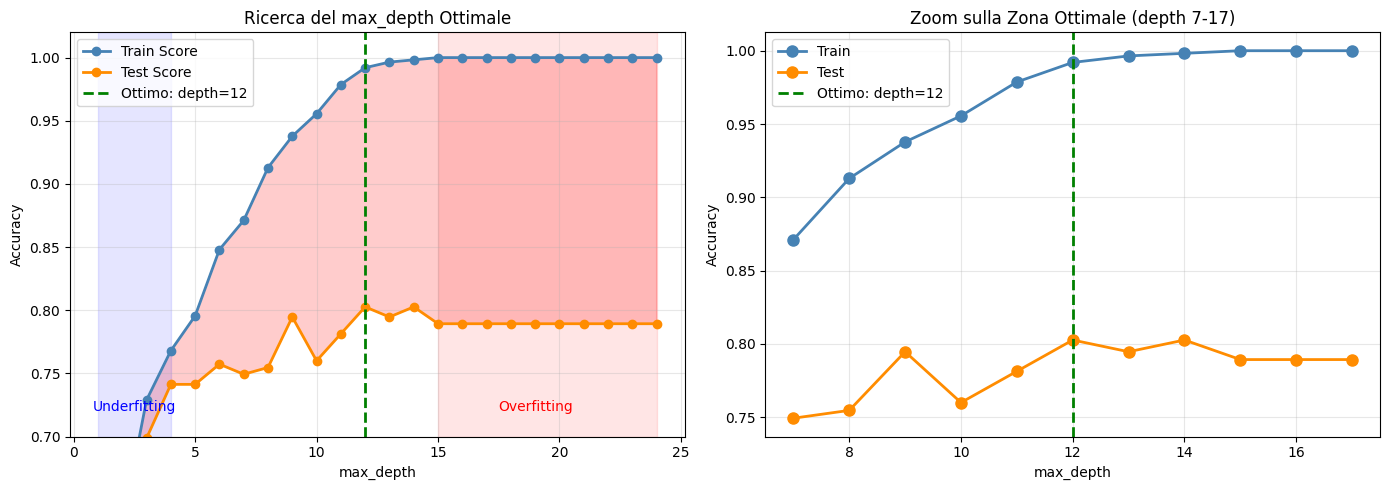


STEP 5: Verifica con Cross-Validation
--------------------------------------------------
Micro-checkpoint 3: CV Mean=0.7787 +/- 0.0237
Cross-Validation Scores: ['0.747', '0.810', '0.777', '0.760', '0.800']
CV Mean: 0.7787 +/- 0.0237

CONCLUSIONE:
  - Il depth ottimale e 12
  - A depth inferiori c'e underfitting
  - A depth superiori inizia l'overfitting
  - La cross-validation conferma la robustezza della scelta



In [11]:
# === ESERCIZIO 5: Trovare la Complessita Ottimale ===
# Perche: Usare la validation per trovare il valore ottimale di max_depth
#         identificando esattamente il punto dove inizia l'overfitting

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier

# STEP 1: Creiamo il dataset
print("STEP 1: Creazione Dataset")
print("-" * 50)

X, y = make_classification(
    n_samples=1500,
    n_features=15,
    n_informative=8,
    n_redundant=4,
    flip_y=0.08,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print(f"Training set: {len(y_train)} campioni")
print(f"Test set: {len(y_test)} campioni")

# --- MICRO-CHECKPOINT 1 ---
assert len(y_train) == 1125, f"Atteso 1125 train, ottenuto {len(y_train)}"
print("Micro-checkpoint 1: Dataset creato correttamente")

# STEP 2: Testiamo diversi valori di max_depth
print("\nSTEP 2: Ricerca del max_depth Ottimale")
print("=" * 70)

depths = range(1, 25)
results = []

print(f"\n{'Depth':>6} {'Train':>10} {'Test':>10} {'Gap':>10} {'Status':>15}")
print("-" * 55)

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    gap = train_score - test_score
    
    # Determina status
    if train_score < 0.80:
        status = "Underfitting"
    elif gap > 0.10:
        status = "Overfitting"
    else:
        status = "OK"
    
    results.append({
        'depth': depth,
        'train': train_score,
        'test': test_score,
        'gap': gap,
        'status': status
    })
    
    print(f"{depth:>6} {train_score:>10.4f} {test_score:>10.4f} {gap:>10.4f} {status:>15}")

# STEP 3: Trova il depth ottimale
print("\n" + "=" * 70)
print("STEP 3: Identificazione Depth Ottimale")
print("=" * 70)

test_scores = [r['test'] for r in results]
best_idx = np.argmax(test_scores)
best_depth = results[best_idx]['depth']
best_test_score = results[best_idx]['test']

# --- MICRO-CHECKPOINT 2 ---
assert best_depth > 2 and best_depth < 20, "Depth ottimale dovrebbe essere intermedio"
print(f"\nMicro-checkpoint 2: Depth ottimale={best_depth}, Test={best_test_score:.4f}")

print(f"\nDEPTH OTTIMALE: {best_depth}")
print(f"   Test Accuracy: {best_test_score:.4f}")
print(f"   Train Accuracy: {results[best_idx]['train']:.4f}")
print(f"   Gap: {results[best_idx]['gap']:.4f}")

# STEP 4: Visualizzazione
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train vs Test
ax1 = axes[0]
depths_list = [r['depth'] for r in results]
train_scores_list = [r['train'] for r in results]
test_scores_list = [r['test'] for r in results]

ax1.plot(depths_list, train_scores_list, 'o-', color='steelblue', 
         linewidth=2, label='Train Score')
ax1.plot(depths_list, test_scores_list, 'o-', color='darkorange', 
         linewidth=2, label='Test Score')
ax1.axvline(best_depth, color='green', linestyle='--', linewidth=2, 
            label=f'Ottimo: depth={best_depth}')
ax1.fill_between(depths_list, train_scores_list, test_scores_list, 
                  alpha=0.2, color='red')

ax1.axvspan(1, 4, alpha=0.1, color='blue')
ax1.axvspan(15, 24, alpha=0.1, color='red')
ax1.text(2.5, 0.72, 'Underfitting', ha='center', fontsize=10, color='blue')
ax1.text(19, 0.72, 'Overfitting', ha='center', fontsize=10, color='red')

ax1.set_xlabel('max_depth')
ax1.set_ylabel('Accuracy')
ax1.set_title('Ricerca del max_depth Ottimale')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.set_ylim(0.7, 1.02)

# Dettaglio zona ottimale
ax2 = axes[1]
zoom_range = range(max(1, best_depth-5), min(25, best_depth+6))
zoom_results = [r for r in results if r['depth'] in zoom_range]

x = [r['depth'] for r in zoom_results]
ax2.plot(x, [r['train'] for r in zoom_results], 'o-', color='steelblue', 
         linewidth=2, markersize=8, label='Train')
ax2.plot(x, [r['test'] for r in zoom_results], 'o-', color='darkorange', 
         linewidth=2, markersize=8, label='Test')
ax2.axvline(best_depth, color='green', linestyle='--', linewidth=2, 
            label=f'Ottimo: depth={best_depth}')

ax2.set_xlabel('max_depth')
ax2.set_ylabel('Accuracy')
ax2.set_title(f'Zoom sulla Zona Ottimale (depth {min(x)}-{max(x)})')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# STEP 5: Verifica con Cross-Validation
print("\nSTEP 5: Verifica con Cross-Validation")
print("-" * 50)

final_model = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
cv_scores = cross_val_score(final_model, X, y, cv=5)

# --- MICRO-CHECKPOINT 3 ---
assert cv_scores.mean() > 0.75, "CV mean dovrebbe essere > 0.75"
print(f"Micro-checkpoint 3: CV Mean={cv_scores.mean():.4f} +/- {cv_scores.std():.4f}")

print(f"Cross-Validation Scores: {[f'{s:.3f}' for s in cv_scores]}")
print(f"CV Mean: {cv_scores.mean():.4f} +/- {cv_scores.std():.4f}")

print(f"""
CONCLUSIONE:
  - Il depth ottimale e {best_depth}
  - A depth inferiori c'e underfitting
  - A depth superiori inizia l'overfitting
  - La cross-validation conferma la robustezza della scelta
""")

STEP 1: Creazione Dataset
--------------------------------------------------
Dataset: 2000 campioni, 20 feature
Micro-checkpoint 1: Dataset creato correttamente

STEP 2: Generazione Learning Curve
--------------------------------------------------
Training sizes testati: [ 160  320  480  640  800  960 1120 1280 1440 1600]
Shape train_scores: (10, 5) (sizes x folds)
Micro-checkpoint 2: Learning curve calcolata

STEP 3: Analisi dei Risultati

  Train Size   Train Mean    Train Std     Val Mean      Val Std      Gap
------------------------------------------------------------------------
         160       1.0000       0.0000       0.8140       0.0131   0.1860
         320       1.0000       0.0000       0.8245       0.0183   0.1755
         480       1.0000       0.0000       0.8330       0.0161   0.1670
         640       0.9981       0.0006       0.8465       0.0215   0.1516
         800       0.9957       0.0020       0.8595       0.0272   0.1362
         960       0.9940       0.0020

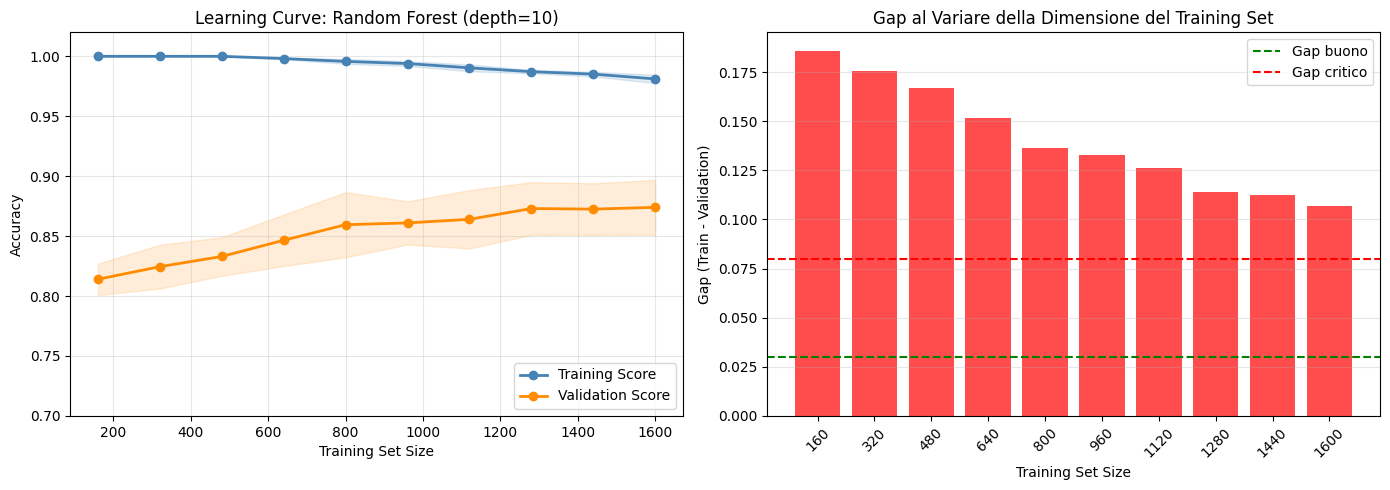


STEP 5: INTERPRETAZIONE

Performance finale (con tutti i dati):
  - Training Score: 0.9811
  - Validation Score: 0.8740
  - Gap: 0.1071

DIAGNOSI: OVERFITTING SIGNIFICATIVO
   Gap grande = il modello sta memorizzando
   Azione: riduci max_depth, aumenta min_samples_leaf

Micro-checkpoint 3: Diagnosi completata - OVERFITTING SIGNIFICATIVO

ANALISI DELLA TENDENZA:
  - La validation accuracy sta ancora CRESCENDO con piu dati
  - -> PIU DATI potrebbero aiutare


In [12]:
# === ESERCIZIO 6: Learning Curve Completa con Interpretazione ===
# Perche: Costruire una learning curve completa e usarla per decidere
#         se servono piu dati o un modello diverso

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier

# STEP 1: Creiamo il dataset
print("STEP 1: Creazione Dataset")
print("-" * 50)

X, y = make_classification(
    n_samples=2000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    flip_y=0.08,
    random_state=42
)

print(f"Dataset: {X.shape[0]} campioni, {X.shape[1]} feature")

# --- MICRO-CHECKPOINT 1 ---
assert X.shape == (2000, 20), "Shape dataset non corretta"
print("Micro-checkpoint 1: Dataset creato correttamente")

# STEP 2: Generiamo la learning curve
print("\nSTEP 2: Generazione Learning Curve")
print("-" * 50)

model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)

train_sizes_rel = np.linspace(0.1, 1.0, 10)

train_sizes_abs, train_scores, val_scores = learning_curve(
    model, X, y,
    train_sizes=train_sizes_rel,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

print(f"Training sizes testati: {train_sizes_abs}")
print(f"Shape train_scores: {train_scores.shape} (sizes x folds)")

# --- MICRO-CHECKPOINT 2 ---
assert len(train_sizes_abs) == 10, "Dovrebbero esserci 10 training sizes"
print("Micro-checkpoint 2: Learning curve calcolata")

# STEP 3: Calcola statistiche
print("\nSTEP 3: Analisi dei Risultati")
print("=" * 70)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

print(f"\n{'Train Size':>12} {'Train Mean':>12} {'Train Std':>12} {'Val Mean':>12} {'Val Std':>12} {'Gap':>8}")
print("-" * 72)
for i, size in enumerate(train_sizes_abs):
    gap = train_mean[i] - val_mean[i]
    print(f"{size:>12} {train_mean[i]:>12.4f} {train_std[i]:>12.4f} "
          f"{val_mean[i]:>12.4f} {val_std[i]:>12.4f} {gap:>8.4f}")

# STEP 4: Visualizzazione
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Learning Curve
ax1 = axes[0]
ax1.plot(train_sizes_abs, train_mean, 'o-', color='steelblue', linewidth=2, 
         markersize=6, label='Training Score')
ax1.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, 
                  alpha=0.15, color='steelblue')

ax1.plot(train_sizes_abs, val_mean, 'o-', color='darkorange', linewidth=2, 
         markersize=6, label='Validation Score')
ax1.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, 
                  alpha=0.15, color='darkorange')

ax1.set_xlabel('Training Set Size')
ax1.set_ylabel('Accuracy')
ax1.set_title('Learning Curve: Random Forest (depth=10)')
ax1.legend(loc='lower right')
ax1.grid(alpha=0.3)
ax1.set_ylim(0.7, 1.02)

# Gap plot
ax2 = axes[1]
gaps = train_mean - val_mean
colors = ['green' if g < 0.03 else 'orange' if g < 0.08 else 'red' for g in gaps]
ax2.bar(range(len(train_sizes_abs)), gaps, color=colors, alpha=0.7)
ax2.set_xticks(range(len(train_sizes_abs)))
ax2.set_xticklabels([str(s) for s in train_sizes_abs], rotation=45)
ax2.set_xlabel('Training Set Size')
ax2.set_ylabel('Gap (Train - Validation)')
ax2.set_title('Gap al Variare della Dimensione del Training Set')
ax2.axhline(0.03, color='green', linestyle='--', label='Gap buono')
ax2.axhline(0.08, color='red', linestyle='--', label='Gap critico')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# STEP 5: Interpretazione Automatica
print("\n" + "=" * 70)
print("STEP 5: INTERPRETAZIONE")
print("=" * 70)

final_gap = train_mean[-1] - val_mean[-1]
final_val = val_mean[-1]

print(f"""
Performance finale (con tutti i dati):
  - Training Score: {train_mean[-1]:.4f}
  - Validation Score: {val_mean[-1]:.4f}
  - Gap: {final_gap:.4f}
""")

# --- MICRO-CHECKPOINT 3 ---
if final_gap < 0.03:
    diagnosis = "BUONA GENERALIZZAZIONE"
    print(f"DIAGNOSI: {diagnosis}")
    print("   Gap piccolo = il modello non sta overfittando")
    print("   Le curve sono vicine e stabili")
elif final_gap < 0.08:
    diagnosis = "LEGGERO OVERFITTING"
    print(f"DIAGNOSI: {diagnosis}")
    print("   Gap moderato = c'e margine di miglioramento")
    print("   Considera: ridurre complessita o piu dati")
else:
    diagnosis = "OVERFITTING SIGNIFICATIVO"
    print(f"DIAGNOSI: {diagnosis}")
    print("   Gap grande = il modello sta memorizzando")
    print("   Azione: riduci max_depth, aumenta min_samples_leaf")

print(f"\nMicro-checkpoint 3: Diagnosi completata - {diagnosis}")

# Analisi tendenza
print("\nANALISI DELLA TENDENZA:")
if val_mean[-1] > val_mean[-2]:
    print("  - La validation accuracy sta ancora CRESCENDO con piu dati")
    print("  - -> PIU DATI potrebbero aiutare")
else:
    print("  - La validation accuracy si e STABILIZZATA")
    print("  - -> Piu dati probabilmente NON aiuteranno molto")

## Glossario essenziale (dentro la sezione 2)
Questa tabella rimane parte della teoria: definisce i termini usati e ti evita ambiguita' quando applichi i passi pratici.

| Termine | Definizione |
|---------|-------------|
| **Generalizzazione** | Capacita di un modello di predire bene dati nuovi mai visti durante il training |
| **Overfitting** | Modello troppo complesso che memorizza il rumore invece dei pattern reali |
| **Underfitting** | Modello troppo semplice che non cattura i pattern presenti nei dati |
| **Bias** | Errore sistematico dovuto a semplificazioni del modello (alto bias = underfitting) |
| **Varianza** | Sensibilita del modello ai dati di training (alta varianza = overfitting) |
| **Trade-off Bias-Varianza** | Impossibilita di minimizzare contemporaneamente bias e varianza |
| **Learning Curve** | Grafico che mostra train e validation score al variare della quantita di dati |
| **Gap Train-Test** | Differenza tra performance su training e test set (alto = overfitting) |
| **Regolarizzazione** | Tecnica che penalizza la complessita del modello per ridurre overfitting |
| **Early Stopping** | Interruzione del training prima che il modello inizi a memorizzare |
| **Cross-Validation Std** | Deviazione standard tra i fold CV (alta = modello instabile) |
| **max_depth** | Parametro Decision Tree che limita la profondita (complessita) |
| **min_samples_leaf** | Numero minimo di campioni richiesti in una foglia |
| **min_samples_split** | Numero minimo di campioni richiesti per effettuare uno split |
| **Rumore Irriducibile** | Errore intrinseco nei dati che nessun modello puo eliminare |
| **Capacita del Modello** | Quanto un modello puo apprendere pattern complessi (complessita) |
| **Validation Set** | Porzione di dati usata per valutare il modello durante lo sviluppo |
| **Test Set** | Porzione di dati usata per valutazione finale (mai toccata prima) |
| **Dropout** | Tecnica deep learning che disattiva neuroni casualmente per ridurre overfitting |
| **Feature Engineering** | Creazione di nuove feature per migliorare la capacita predittiva |

## Errori comuni e debug rapido (dentro la sezione 5)
Questi errori completano gli esercizi: leggi sintomi, causa probabile e fix prima di cambiare codice.

| # | Errore | Problema | Soluzione |
|---|--------|----------|-----------|
| 1 | Valutare solo sul training set | Non rileva overfitting, metriche illusorie | Sempre usare test set separato o cross-validation |
| 2 | Non fare train/test split PRIMA del preprocessing | Data leakage, stime ottimistiche | Split prima, poi preprocessing separato |
| 3 | Ignorare il gap train-test | Non riconoscere overfitting | Monitorare sempre la differenza (target < 10%) |
| 4 | Decision Tree senza max_depth | Albero cresce fino a memorizzare tutto | Sempre impostare max_depth iniziale |
| 5 | Confondere alta accuracy training con buon modello | Modello perfetto su train puo essere pessimo su test | L'unica metrica che conta e quella sul test |
| 6 | Non usare cross-validation | Singolo split puo essere non rappresentativo | Usare cv=5 o cv=10 per stime robuste |
| 7 | Aumentare complessita senza verificare | Puo peggiorare le cose se c'e gia overfitting | Sempre validare dopo ogni modifica |
| 8 | Raccogliere piu dati per underfitting | Piu dati non risolvono modello troppo semplice | Per underfitting: aumentare complessita modello |
| 9 | Ridurre regolarizzazione quando c'e overfitting | Peggiora la situazione | Per overfitting: aumentare regolarizzazione |
| 10 | Non visualizzare le learning curves | Perdi informazioni diagnostiche importanti | Sempre plottare train vs val al variare dei dati |

# 6) Conclusione Operativa

---

## Take-Home Messages

Questa lezione ti ha fornito gli strumenti diagnostici per identificare e risolvere i due problemi fondamentali del ML: overfitting e underfitting.

---

## I 5 Concetti Fondamentali

| # | Concetto | Sintesi | Formula/Regola |
|---|----------|---------|----------------|
| 1 | **Trade-off bias-varianza** | Non puoi minimizzare entrambi simultaneamente | $E = \text{Bias}^2 + \text{Var} + \text{Noise}$ |
| 2 | **Overfitting = memorizzazione** | Train alto, Test basso, Gap > 10% | Cura: ↓ complessità |
| 3 | **Underfitting = semplificazione** | Train basso, Test basso, Gap piccolo | Cura: ↑ complessità |
| 4 | **Learning curves = diagnostica** | Train vs Val al variare dei dati | Gap crescente = overfit |
| 5 | **Generalizzazione è l'obiettivo** | L'unica metrica che conta è sul test set | Train score è solo indicativo |

---

## La Tabella Diagnostica Definitiva

| Train Score | Test Score | Gap | Diagnosi | Azione |
|-------------|------------|-----|----------|--------|
| < 80% | < 80% | < 5% | **Underfitting** | ↑ max_depth, ↑ n_estimators, + features |
| > 95% | < 80% | > 15% | **Overfitting grave** | ↓ max_depth, ↑ min_samples_leaf, + dati |
| > 90% | < 85% | 5-15% | **Overfitting lieve** | Regolarizzazione, early stopping |
| 85-95% | 80-90% | < 5% | **Buon modello** | ✅ Mantieni, valida ulteriormente |
| 90-95% | 85-92% | < 5% | **Ottimo modello** | ✅ Pronto per produzione |

---

## Rimedi Specifici

### Per Overfitting (Gap > 10%)

| Azione | Effetto | Parametro |
|--------|---------|-----------|
| Ridurre max_depth | Alberi meno profondi | max_depth = 3-5 |
| Aumentare min_samples_leaf | Foglie più "robuste" | min_samples_leaf = 5-10 |
| Aumentare min_samples_split | Split più conservativi | min_samples_split = 5-20 |
| Aggiungere regolarizzazione | Penalizza complessità | L1/L2 nei lineari |
| Usare subsample < 1.0 | Stocasticità | subsample = 0.7-0.9 |
| Early stopping | Fermare prima dell'overfit | patience = 10-50 |
| Più dati | Più generalità | Se disponibili |

### Per Underfitting (Train < 80%)

| Azione | Effetto | Parametro |
|--------|---------|-----------|
| Aumentare max_depth | Alberi più profondi | max_depth = 10-20 o None |
| Aumentare n_estimators | Più alberi nell'ensemble | n_estimators = 200-500 |
| Ridurre regolarizzazione | Meno vincoli | C ↑ in LogReg, alpha ↓ in Ridge |
| Feature engineering | Pattern più complessi | Interazioni, polinomiali |
| Modello più potente | Maggiore capacità | RF → GB → XGBoost |

---

## Learning Curves: Come Leggerle

```
UNDERFITTING                    OVERFITTING                    GIUSTO
    |                               |                               |
    | ___Train___                   | _____Train____                | ___Train___
    |     Val                       |                               |    ___Val___
    | ___Val___                     |      Val                      |
    +--------→ Dati                 +--------→ Dati                 +--------→ Dati
    
    Gap piccolo                     Gap grande                      Gap piccolo
    Entrambi bassi                  Train alto, Val basso           Entrambi alti
    → ↑ Complessità                 → ↓ Complessità                 → ✅ OK!
```

---

## Workflow Diagnostico Standard

```
┌────────────────────────────────────────────────────────────────┐
│ 1. CALCOLA TRAIN E TEST SCORE                                   │
│    train_score = model.score(X_train, y_train)                 │
│    test_score = model.score(X_test, y_test)                    │
├────────────────────────────────────────────────────────────────┤
│ 2. CALCOLA IL GAP                                               │
│    gap = train_score - test_score                              │
├────────────────────────────────────────────────────────────────┤
│ 3. DIAGNOSI                                                     │
│    if train_score < 0.80: "Underfitting"                       │
│    elif gap > 0.10: "Overfitting"                              │
│    else: "OK"                                                   │
├────────────────────────────────────────────────────────────────┤
│ 4. APPLICA RIMEDIO                                              │
│    Underfitting → ↑ complessità                                │
│    Overfitting → ↓ complessità                                 │
├────────────────────────────────────────────────────────────────┤
│ 5. VALIDA CON LEARNING CURVE                                    │
│    learning_curve(model, X, y, cv=5)                           │
└────────────────────────────────────────────────────────────────┘
```

---

## Codice Template

```python
# Template diagnostica completa
def diagnose_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    gap = train_score - test_score
    
    print(f"Train: {train_score:.3f}")
    print(f"Test:  {test_score:.3f}")
    print(f"Gap:   {gap:.3f}")
    
    if train_score < 0.80:
        return "UNDERFITTING: aumenta complessità"
    elif gap > 0.10:
        return "OVERFITTING: riduci complessità"
    else:
        return "OK: buona generalizzazione"

# Template learning curve
from sklearn.model_selection import learning_curve
train_sizes, train_scores, val_scores = learning_curve(
    model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5
)
```

---

## Collegamento alle Prossime Lezioni

| Prossima Lezione | Cosa imparerai | Collegamento |
|------------------|----------------|--------------|
| **Lesson 13 - Pipeline** | Concatenare preprocessing + model | Evitare data leakage |
| **Lesson 15 - XGBoost/LightGBM** | Early stopping integrato | Anti-overfitting automatico |
| **Lesson 16 - Feature Importance** | Quali feature eliminare | Ridurre overfitting |

---

## Verifica Finale

Prima di procedere, dovresti saper rispondere a:

1. **Cos'è il trade-off bias-varianza?**
   - *Non puoi minimizzare entrambi: riducendo uno aumenti l'altro*

2. **Come riconosco l'overfitting?**
   - *Train score alto (~100%), test score basso, gap > 10%*

3. **Come riconosco l'underfitting?**
   - *Entrambi train e test score bassi (< 80%), gap piccolo*

4. **Cosa mi dice la learning curve?**
   - *Come cambiano train e val al variare dei dati; gap = overfit, entrambi bassi = underfit*

# 7) Checklist di fine lezione

## Prima di Allenare

- [ ] Ho abbastanza dati rispetto alle feature?
- [ ] Ho fatto train/test split PRIMA del preprocessing?
- [ ] Ho scelto un modello con complessita ragionevole?
- [ ] Ho impostato max_depth per Decision Tree?

## Dopo l'Allenamento

- [ ] Train score ragionevole (> 0.80)?
- [ ] Test score accettabile (> 0.75)?
- [ ] Gap train-test < 10%?
- [ ] Cross-validation con std < 0.05?

## Se Overfitting (Gap > 10%)

- [ ] Ridurre max_depth
- [ ] Aumentare min_samples_leaf
- [ ] Aggiungere regolarizzazione
- [ ] Rimuovere feature poco importanti
- [ ] Raccogliere piu dati

## Se Underfitting (Train Score < 80%)

- [ ] Aumentare complessita modello
- [ ] Aggiungere feature engineering
- [ ] Ridurre regolarizzazione
- [ ] Verificare preprocessing

## Verifica Finale

- [ ] Learning curve mostra convergenza?
- [ ] Cross-validation stabile?
- [ ] Modello interpretabile per il contesto?
- [ ] Performance accettabile per l'applicazione?

---

# 8) Changelog Didattico

Questo changelog traccia l'evoluzione del materiale didattico.

---

## Storico delle Versioni

| Versione | Data | Autore | Modifiche |
|----------|------|--------|-----------|
| 1.0 | Originale | - | Versione iniziale del notebook |
| 2.0 | 2025-01-XX | - | Prima strutturazione con 9 sezioni e checkpoint |
| 2.1 | 2025-01-05 | - | Allineato alle 8 sezioni obbligatorie; glossario integrato; errori comuni inglobati |
| 2.2 | 2025-01-XX | Copilot | **Espansione didattica completa**: header con mappa lezione, obiettivi O1-O6 verificabili, prerequisiti strutturati, formula bias-varianza annotata, intuizione visiva U-curve, tabella diagnostica definitiva, rimedi specifici per overfit/underfit, learning curves come leggerle, workflow diagnostico, codice template, domande verifica |

---

## Dettaglio Modifiche v2.2

### Celle Modificate

| Cella | Tipo di Modifica | Contenuto Aggiunto |
|-------|------------------|-------------------|
| Header (#VSC-e7f528ae) | Espansione maggiore | Mappa lezione 8 sezioni, obiettivi O1-O6 con livelli, prerequisiti tabellari, formula bias-varianza, intuizione U-curve, tabella due modi per fallire |
| Conclusione (#VSC-75620e32) | Espansione significativa | 5 concetti chiave, tabella diagnostica definitiva, rimedi specifici per overfit/underfit, learning curves interpretazione, workflow 5 step, codice template, domande verifica |
| Changelog (#VSC-f057c5de) | Aggiornamento | Documentazione completa delle modifiche |

### Metriche di Espansione

| Metrica | Prima | Dopo | Delta |
|---------|-------|------|-------|
| Caratteri header | ~900 | ~4800 | +3900 |
| Tabelle header | 1 | 6 | +5 |
| Rimedi specifici | 0 | 14 | +14 |
| Codice template | 1 snippet | 2 funzioni | +1 |

---

## Razionale delle Modifiche

1. **Formula bias-varianza**: Fondamentale per capire PERCHÉ esiste il trade-off
2. **Intuizione U-curve**: Visualizzazione del sweet spot tra underfit e overfit
3. **Tabella diagnostica**: Riferimento rapido per diagnosi e azione
4. **Rimedi specifici**: Lista actionable di parametri da modificare
5. **Learning curves interpretazione**: Come leggere i grafici diagnostici
6. **Workflow standardizzato**: Procedura sempre uguale da seguire

---

**Fine della lezione**